In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

from keras.models import Sequential
from keras.layers import InputLayer, Bidirectional, LSTM, Dense, Dropout
from keras.optimizers import Adam
from keras.losses import MeanSquaredError
from keras.metrics import RootMeanSquaredError
from keras.constraints import MaxNorm
from keras.callbacks import ModelCheckpoint

import time

In [2]:
filepath = 'C:/Users/ss230/Documents/Study/NSIDC/Edited Data/N_Sea_Ice_Index_Regional_Monthly_Data_G02135_v3.0.xlsx'
Kara = pd.read_excel(filepath, sheet_name='Kara-Extent-km^2')

In [3]:
import sys
sys.path.append('C:/Users/ss230/Documents/Study/NSIDC/NH/')
import Function as fp

In [4]:
fp.month_mapping(Kara)
fp.date_time(Kara)

,Extent,Date
0,917992.880,1979-01-01
1,917992.880,1979-02-01
2,917992.880,1979-03-01
3,917992.880,1979-04-01
4,917992.880,1979-05-01
...,...,...
533,728642.743,2023-06-01
534,437024.646,2023-07-01
535,202260.789,2023-08-01
536,98103.856,2023-09-01


In [5]:
scaler = MinMaxScaler()
Kara['Extent'] = scaler.fit_transform(Kara['Extent'].values.reshape(-1, 1))

In [6]:
def df_to_X_y(df, window_size):
    df_as_np = df.to_numpy()
    X = []
    y = []
    lead_time = 9
    for i in range(len(df_as_np) - window_size - lead_time + 1):
        window_data = df_as_np[i:i+window_size]
        row = [[a] for a in window_data]
        X.append(row)
        label = df_as_np[i+window_size+lead_time-1]
        y.append(label)
    return np.array(X), np.array(y)

In [7]:
extent = Kara['Extent']
W_S=12
X,y = df_to_X_y(extent, W_S)
X.shape, y.shape

((518, 12, 1), (518,))

In [8]:
X_train, y_train = X[:420], y[:420]
X_val, y_val = X[420:472], y[420:472]
X_test, y_test = X[472:], y[472:]

In [9]:
model = Sequential()
model.add(InputLayer((W_S, 1)))
model.add(Bidirectional(LSTM(128, activation='relu', kernel_constraint=MaxNorm(1.0), return_sequences=True)))
model.add(Dropout(0.5))
model.add(Bidirectional(LSTM(64, activation='relu', kernel_constraint=MaxNorm(1.0), return_sequences=True)))
model.add(Dropout(0.2))
model.add(Bidirectional(LSTM(32, activation='relu', kernel_constraint=MaxNorm(1.0))))
model.add(Dense(1, activation='linear'))

cp = ModelCheckpoint('Kara_model_LT9/', save_best_only=True)
model.compile(loss=MeanSquaredError(), optimizer=Adam(0.0001), metrics=[RootMeanSquaredError()])

In [10]:
stime = time.time()
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50, batch_size=8, callbacks=[cp])
etime = time.time()

Epoch 1/50
53/53 [==============================] - 37s 483ms/step - loss: 0.5858 - root_mean_squared_error: 0.7654 - val_loss: 0.3351 - val_root_mean_squared_error: 0.5788
Epoch 2/50
53/53 [==============================] - 26s 490ms/step - loss: 0.1713 - root_mean_squared_error: 0.4139 - val_loss: 0.1513 - val_root_mean_squared_error: 0.3889
Epoch 3/50
53/53 [==============================] - 26s 496ms/step - loss: 0.0876 - root_mean_squared_error: 0.2960 - val_loss: 0.1335 - val_root_mean_squared_error: 0.3654
Epoch 4/50
53/53 [==============================] - 26s 509ms/step - loss: 0.0765 - root_mean_squared_error: 0.2766 - val_loss: 0.1161 - val_root_mean_squared_error: 0.3407
Epoch 5/50
53/53 [==============================] - 25s 483ms/step - loss: 0.0646 - root_mean_squared_error: 0.2542 - val_loss: 0.0990 - val_root_mean_squared_error: 0.3146
Epoch 6/50
53/53 [==============================] - 26s 502ms/step - loss: 0.0605 - root_mean_squared_error: 0.2460 - val_loss: 0.0816 

53/53 [==============================] - 27s 510ms/step - loss: 0.0241 - root_mean_squared_error: 0.1553 - val_loss: 0.0251 - val_root_mean_squared_error: 0.1583
Epoch 29/50
53/53 [==============================] - 26s 503ms/step - loss: 0.0234 - root_mean_squared_error: 0.1530 - val_loss: 0.0221 - val_root_mean_squared_error: 0.1487
Epoch 30/50
53/53 [==============================] - 28s 529ms/step - loss: 0.0205 - root_mean_squared_error: 0.1432 - val_loss: 0.0219 - val_root_mean_squared_error: 0.1481
Epoch 31/50
53/53 [==============================] - 3s 63ms/step - loss: 0.0217 - root_mean_squared_error: 0.1474 - val_loss: 0.0233 - val_root_mean_squared_error: 0.1525
Epoch 32/50
53/53 [==============================] - 3s 60ms/step - loss: 0.0202 - root_mean_squared_error: 0.1422 - val_loss: 0.0288 - val_root_mean_squared_error: 0.1696
Epoch 33/50
53/53 [==============================] - 30s 575ms/step - loss: 0.0195 - root_mean_squared_error: 0.1398 - val_loss: 0.0194 - val_root

In [11]:
time = (etime - stime)/60
print(f'{time} minutes')

14.563540597756704 minutes


In [12]:
loss = history.history['loss']
epochs = list(range(1, len(loss) + 1))

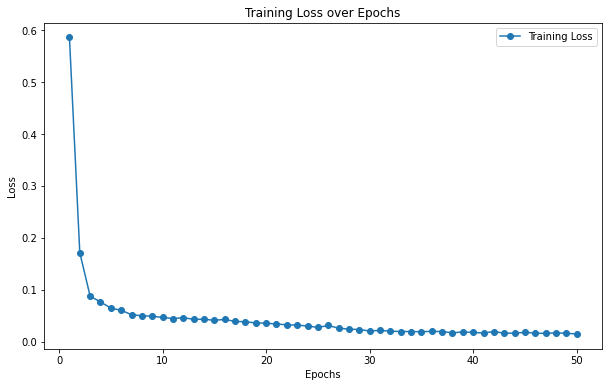

In [13]:
plt.figure(figsize=(10, 6))
plt.plot(epochs, loss, label='Training Loss', marker='o', linestyle='-')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()
plt.show()

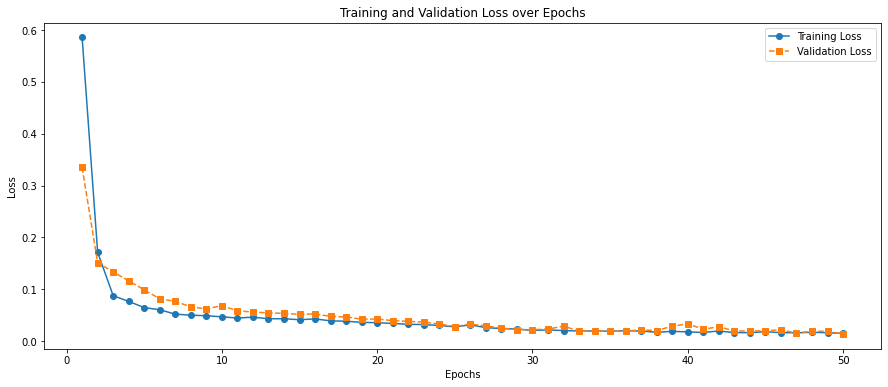

In [14]:
training_loss = history.history['loss']
validation_loss = history.history['val_loss']
epochs = range(1, len(training_loss) + 1)

plt.figure(figsize=(15,6))
plt.plot(epochs, training_loss, label='Training Loss', marker='o', linestyle='-')
plt.plot(epochs, validation_loss, label='Validation Loss', marker='s', linestyle='--')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs')
plt.legend()
plt.show()

In [15]:
from tensorflow.keras.models import load_model
model1 = load_model('Kara_model_LT9/')

In [16]:
test_predictions = model1.predict(X_test)

2/2 [==============================] - 2s 50ms/step


In [17]:
mse = mean_squared_error(y_test, test_predictions)
print('RMSE :', np.sqrt(mse))

mae = mean_absolute_error(y_test, test_predictions)
print('MAE :', mae)

RMSE : 0.12676446309382636
MAE : 0.08942528186848916


In [18]:
test_predictions = scaler.inverse_transform(test_predictions)
test_original = scaler.inverse_transform(y_test.reshape(-1,1))

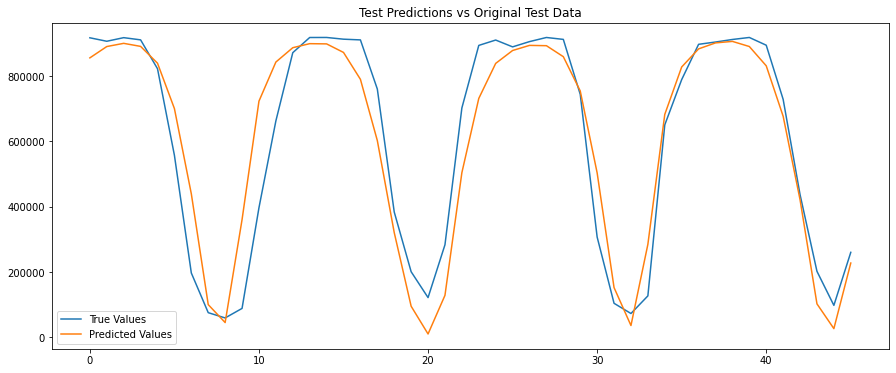

In [19]:
plt.figure(figsize=(15,6))
plt.plot(test_original, label='True Values')
plt.plot(test_predictions, label='Predicted Values')
plt.title('Test Predictions vs Original Test Data')
plt.legend()
plt.show()

In [20]:
predictions = model1.predict(X)

17/17 [==============================] - 1s 49ms/step


In [21]:
predictions = scaler.inverse_transform(predictions)
Original = scaler.inverse_transform(y.reshape(-1,1))

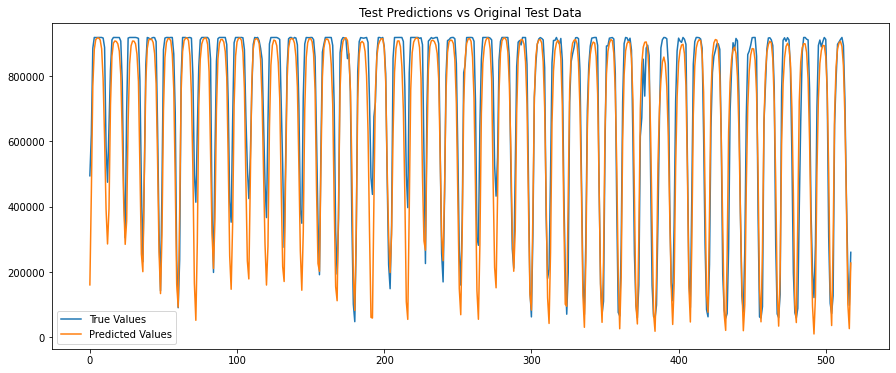

In [22]:
plt.figure(figsize=(15,6))
plt.plot(Original, label='True Values')
plt.plot(predictions, label='Predicted Values')
plt.title('Test Predictions vs Original Test Data')
plt.legend()
plt.show()